In [1]:
from __future__ import division #always returns approximations from divisions
import numpy as np
import matplotlib.pyplot as plt
import ephem #for astronomy calculations, converting coordinate systems
import pandas as pd
from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
v_df = pd.read_csv('voy1_ephemeris_p1.txt', skiprows = 55, skipfooter=1147-1092, engine='python') # df of info about voyager's position
s_df = pd.DataFrame(columns = ['source_id', 'g_abs', 'bp_rp', 'parallax']) # df of info about stars

print(v_df)

                    date na1 na2         ra       dec  Unnamed: 5
0      1977-Sep-06 00:00           65.45370  25.53700         NaN
1      1977-Sep-16 00:00           66.76777  25.78933         NaN
2      1977-Sep-26 00:00           65.96444  25.65060         NaN
3      1977-Oct-06 00:00           64.31556  25.34236         NaN
4      1977-Oct-16 00:00           61.75803  24.80495         NaN
...                  ...  ..  ..        ...       ...         ...
1030   2005-Nov-18 00:00          255.79088  11.82527         NaN
1031   2005-Nov-28 00:00          255.89725  11.80246         NaN
1032   2005-Dec-08 00:00          256.00691  11.78925         NaN
1033   2005-Dec-18 00:00          256.11668  11.78606         NaN
1034   2005-Dec-28 00:00          256.22355  11.79296         NaN

[1035 rows x 6 columns]


In [3]:
for i in range(len(v_df.index)):
    #query to cone search around given voyager's position
    query = """SELECT source_id, phot_g_mean_mag+5*log10(ABS(parallax)/1000)+5 AS g_abs, bp_rp, parallax, abs(1000/parallax) AS dist
    FROM gaiaedr3.gaia_source
    WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', """ + str(v_df['ra'][i]) + """,""" + str(v_df['dec'][i]) + """, 0.035603))
    """
    
    results = Gaia.launch_job_async(query).get_results() #results from gaia query
    results = results.to_pandas().dropna() #convert to pandas

    s_df = pd.concat([s_df, results], ignore_index = True)
    
s_df = s_df.drop_duplicates(subset=['source_id']) #only keep unique rows
print(s_df)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [4]:
#s_df.to_csv('voyager1_stars_p1.csv') #save stars
s_df = s_df[s_df['dist'] <= 100]
s_df.to_csv('voy1_stars_p1.csv')
print(s_df)

                 source_id      g_abs     bp_rp   parallax       dist
97      149730638774998016   8.838866  2.231787  12.107673  82.592251
2134    611978173336479744  15.119835  2.438141 -10.167584  98.351785
2180    660949807058832256   2.599319  0.534560  15.283526  65.429929
2184    660950558679219328  10.168928  2.408278  15.302572  65.348491
2646   3870184928662682752  14.497686  3.931446  13.096136  76.358403
2702   3817272482059636224  10.152660  2.831788  11.652807  85.816233
3267   3705719227761753216   5.945805  1.075739  10.884566  91.873210
3294   3708841114934118784   8.219874  2.097004  10.989238  90.998118
3786   3723406040525056128  11.123284  2.811724  19.885015  50.289126
4564   1161526798003788800  17.045074  2.371353  17.876382  55.939731
5410   1164899348057808896   9.026822  2.101945  10.857008  92.106409
5591   1189346748582562816  12.260833  2.566167  10.574005  94.571547
5593   1189346748583631104   3.956852  0.739115  10.399171  96.161511
5596   1189346989101

In [5]:
v2_df = pd.read_csv('voy1_ephemeris_p2.txt', skiprows = 55, skipfooter=212-157, engine='python') # df of info about voyager's position after 10000 days
s2_df = pd.DataFrame(columns = ['source_id', 'g_abs', 'bp_rp', 'parallax']) # df of info about stars encountered after 10000 days

print(v2_df)

                  date na1 na2         ra       dec  Unnamed: 5
0    2006-Jan-01 00:00          256.26481  11.79854         NaN
1    2006-Apr-01 00:00          256.63917  12.21235         NaN
2    2006-Jul-01 00:00          255.93466  12.45279         NaN
3    2006-Oct-01 00:00          255.67343  12.05224         NaN
4    2007-Jan-01 00:00          256.49260  11.81825         NaN
..                 ...  ..  ..        ...       ...         ...
95   2029-Oct-01 00:00          258.88496  12.19363         NaN
96   2030-Jan-01 00:00          259.31512  12.05861         NaN
97   2030-Apr-01 00:00          259.52212  12.27745         NaN
98   2030-Jul-01 00:00          259.13940  12.41087         NaN
99   2030-Oct-01 00:00          258.96052  12.19711         NaN

[100 rows x 6 columns]


In [8]:
for i in range(len(v2_df.index)):
    #query to cone search around given voyager's position after 10000 days
    query = """SELECT source_id, phot_g_mean_mag+5*log10(ABS(parallax)/1000)+5 AS g_abs, bp_rp, parallax, abs(1000/parallax) AS dist
    FROM gaiaedr3.gaia_source
    WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', """ + str(v_df['ra'][i]) + """,""" + str(v_df['dec'][i]) + """, 0.035603))
    """
    
    results = Gaia.launch_job_async(query).get_results() #results from gaia query
    results = results.to_pandas().dropna() #convert to pandas

    s2_df = pd.concat([s2_df, results], ignore_index = True) #database of stars encountered after 10000 days
    
s2_df = s2_df.drop_duplicates(subset=['source_id']) #only keep unique rows

s2_df = s2_df[s2_df['dist'] <= 100]

print(s2_df)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [11]:
voy1_stars = s_df.append(s2_df, sort = False)
voy1_stars = voy1_stars.drop_duplicates(subset=['source_id']) #only keep unique rows

print(voy1_stars)
voy1_stars.to_csv('voy1_stars.csv')

                 source_id      g_abs     bp_rp   parallax       dist
97      149730638774998016   8.838866  2.231787  12.107673  82.592251
2134    611978173336479744  15.119835  2.438141 -10.167584  98.351785
2180    660949807058832256   2.599319  0.534560  15.283526  65.429929
2184    660950558679219328  10.168928  2.408278  15.302572  65.348491
2646   3870184928662682752  14.497686  3.931446  13.096136  76.358403
2702   3817272482059636224  10.152660  2.831788  11.652807  85.816233
3267   3705719227761753216   5.945805  1.075739  10.884566  91.873210
3294   3708841114934118784   8.219874  2.097004  10.989238  90.998118
3786   3723406040525056128  11.123284  2.811724  19.885015  50.289126
4564   1161526798003788800  17.045074  2.371353  17.876382  55.939731
5410   1164899348057808896   9.026822  2.101945  10.857008  92.106409
5591   1189346748582562816  12.260833  2.566167  10.574005  94.571547
5593   1189346748583631104   3.956852  0.739115  10.399171  96.161511
5596   1189346989101

<ipython-input-12-83501995fe7f>:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("hot"))
  color_map.set_bad(color='white') #set color as white for masked values


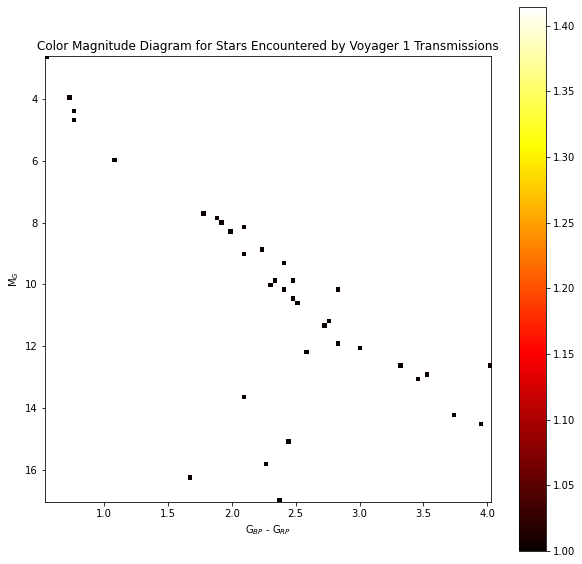

In [12]:
#build hr diagram
voy1_stars = pd.read_csv('voy1_stars.csv') #get csv

histogram, xedges, yedges = np.histogram2d(
   voy1_stars['bp_rp'], voy1_stars['g_abs'], bins=100)

histogram = np.ma.masked_where(histogram == 0.0, histogram) #map zero values
histogram = histogram.T #list bins with common y range

color_map = plt.cm.get_cmap("hot") #set colors for diagram
color_map.set_bad(color='white') #set color as white for masked values

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]] #bounding box in data

#plotting

plt.figure(figsize=(10, 10))

#plt.savefig('gaia_100_parsecs.png')
plt.imshow(np.sqrt(histogram), origin='lower', cmap=color_map,
    extent=extent, aspect=(extent[1]-extent[0])/(extent[3]-extent[2])
    )

plt.colorbar()
plt.title("Color Magnitude Diagram for Stars Encountered by Voyager 1 Transmissions")
plt.xlabel('G$_{BP}$ - G$_{RP}$')
plt.ylabel('M$_G$')
plt.gca().invert_yaxis()
plt.savefig('voy1_stars_hr.png')

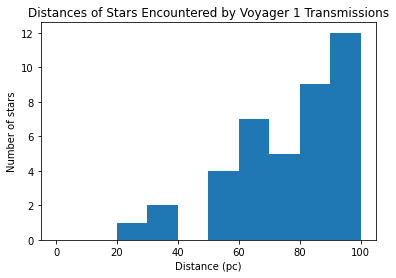

In [15]:
voy1_stars = pd.read_csv('voy1_stars.csv') #get csv

plt.hist(abs(1000/voy1_stars['parallax']), bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]) #plot parallax (mas) converted to distance (pc) in histogram

plt.title("Distances of Stars Encountered by Voyager 1 Transmissions") #labels
plt.xlabel("Distance (pc)")
plt.ylabel("Number of stars")

plt.savefig("voy1_stars_dist.png")
plt.show()